## Plots for thesis seminar

In [1]:
import numpy as np
import xarray as xr
from distributed import Client
import dask_jobqueue
#import daskdataframe as dd
import matplotlib.pyplot as plt
import glob
import netCDF4 as nc
import zarr
import nc_time_axis
import xskillscore as xs
import cartopy as cart
#%run data_handler.ipynb
import numbers
#np.set_printoptions(threshold=np.inf)
from scipy.special import erfinv, erf
import xskillscore as xs

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ContextualVersionConflict((numpy 1.23.5 (/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages), Requirement.parse('numpy<1.23.0,>=1.16.5'), {'scipy'}))'.
  numba.core.entrypoints.init_all()
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ContextualVersionConflict((numpy 1.23.5 (/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages), Requirement.parse('numpy<1.2

In [2]:
#Chicago
LAT1        = 41.8781
LON1        = (360-87.6298)%360
#Boston
# LAT          = 42.3601
# LON          = (360-71.0589)%360
# #Bengaluru:
LAT2        = 12.9716
LON2        = 77.5946
#Berkeley
# LAT       = 37.8715
# LON       = (360-122.2730)%360
savefigs   = '/global/scratch/users/harsha/savefigs/Feb21/'
cesm2_path = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals      = '/global/scratch/users/harsha/LENS/cesm2/cvals/'
cvals_det  = '/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/'
loc1       = 'Chicago/'
locn1      = 'Chicago'
loc2       = 'Bengaluru/'
locn2      = 'Bengaluru'
cvals1     = '/global/scratch/users/harsha/LENS/cesm2/tmax_mem'
print(LAT1,LON1)
print(LAT2,LON2)

41.8781 272.3702
12.9716 77.5946


In [3]:
def to_daily(ds):
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), day=("time", day.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "day")).unstack("time")  

In [4]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=10, walltime='6:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(3)

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46571 instead
  warnings.warn(


In [5]:
cluster

Dashboard: http://10.0.39.1:46571/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.39.1:40769,Workers: 0
Dashboard: http://10.0.39.1:46571/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [12]:
pi_year0 = '1850'
pi_year1 = '1879'
ic_year0 = '2071'
ic_year1 = '2100'
pi_year  = 1865
eoc_year = 2085
doy      =  211# day_of_year #211 = Jul 30
date     = 'Jul30'
date0    = 'July 30'

In [14]:
# Set paths for detrended local tmax - warming, no warming and corrected.
dpi_detpath1      = cvals_det+loc1+'tpi_det'+date+'_'+pi_year0+'_'+pi_year1+'_loc.zarr'
deoc_detpath1     = cvals_det+loc1+'teoc_det'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
dmsc_detpath1     = cvals_det+loc1+'tmsc_det'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
dmc_detpath1      = cvals_det+loc1+'tmc_det'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
#
dpi_detpath2      = cvals_det+loc2+'tpi_det'+date+'_'+pi_year0+'_'+pi_year1+'_loc.zarr'
deoc_detpath2     = cvals_det+loc2+'teoc_det'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
dmsc_detpath2     = cvals_det+loc2+'tmsc_det'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
dmc_detpath2      = cvals_det+loc2+'tmc_det'+date+'_'+ic_year0+'_'+ic_year1+'_loc.zarr'
print(dpi_detpath1)

/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/Chicago/tpi_detJul30_1850_1879_loc.zarr


In [15]:
%%time
# tpi_loc1_det     = xr.open_zarr(dpi_detpath1).detrended_tmax
# teoc_loc1_det    = xr.open_zarr(deoc_detpath1).detrended_tmax
# tmc_loc1_det     = xr.open_zarr(dmc_detpath1).detrended_tmax
# tmsc_loc1_det    = xr.open_zarr(dmsc_detpath1).detrended_tmax
#
tpi_loc2_det     = xr.open_zarr(dpi_detpath2).detrended_tmax
teoc_loc2_det    = xr.open_zarr(deoc_detpath2).detrended_tmax
tmc_loc2_det     = xr.open_zarr(dmc_detpath2).detrended_tmax
tmsc_loc2_det    = xr.open_zarr(dmsc_detpath2).detrended_tmax

CPU times: user 439 ms, sys: 26.7 ms, total: 465 ms
Wall time: 441 ms


In [17]:
%%time
quants      = np.arange(0.0,1.01,0.01)
#Compute quantile function - Jan 1 tmax
# qpi_loc1_det   = tpi_loc1_det.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
# qeoc_loc1_det  = teoc_loc1_det.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
# qmc_loc1_det   = tmc_loc1_det.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
# qmsc_loc1_det  = tmsc_loc1_det.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
#
qpi_loc2_det   = tpi_loc2_det.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qeoc_loc2_det  = teoc_loc2_det.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qmc_loc2_det   = tmc_loc2_det.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')
qmsc_loc2_det  = tmsc_loc2_det.chunk(dict(mtime=-1)).quantile(quants,dim='mtime')

CPU times: user 699 ms, sys: 41.3 ms, total: 740 ms
Wall time: 707 ms


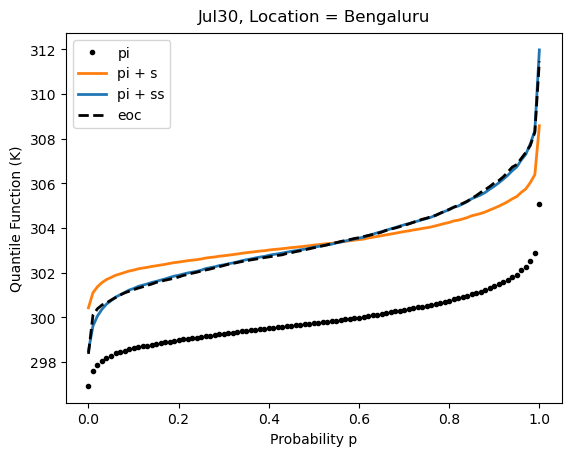

CPU times: user 9.87 s, sys: 534 ms, total: 10.4 s
Wall time: 20.3 s


In [19]:
%%time
plt.plot(quants,qpi_loc2_det,'.',color='k',label= 'pi',lw=2)
plt.plot(quants,qmc_loc2_det,color='tab:orange',label= 'pi + s',lw=2)
plt.plot(quants,qmsc_loc2_det,'tab:blue',label='pi + ss',lw=2)
plt.plot(quants,qeoc_loc2_det,'k--',label='eoc',lw=2)
#
plt.legend(loc='upper left')
plt.title(date +', Location = '+locn2, y=1.01)
plt.ylabel('Quantile Function (K)', fontsize =10)
plt.xlabel('Probability p', fontsize = 10)
plt.show()